In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import date

In [31]:
clim = pd.read_csv('jena_climate_2009_2016.csv', index_col = 0)

In [32]:
clim = clim.reset_index()
clim.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [34]:
df = clim[['Date Time','T (degC)']].rename(columns = {'T (degC)':'T','Date Time':'datetime'})
df.head()

,datetime,T
0,01.01.2009 00:10:00,-8.02
1,01.01.2009 00:20:00,-8.41
2,01.01.2009 00:30:00,-8.51
3,01.01.2009 00:40:00,-8.31
4,01.01.2009 00:50:00,-8.27


<AxesSubplot:>

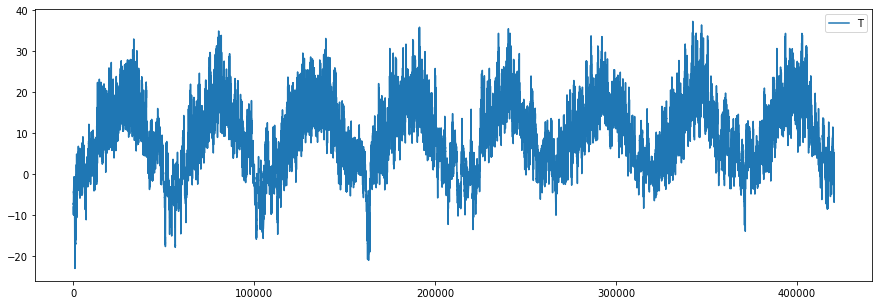

In [37]:
df.plot(figsize = (15,5))

In [38]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [40]:
type(df['datetime'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [69]:
df.head(10)

,datetime,T
0,2009-01-01 00:10:00,-8.02
1,2009-01-01 00:20:00,-8.41
2,2009-01-01 00:30:00,-8.51
3,2009-01-01 00:40:00,-8.31
4,2009-01-01 00:50:00,-8.27
5,2009-01-01 01:00:00,-8.05
6,2009-01-01 01:10:00,-7.62
7,2009-01-01 01:20:00,-7.62
8,2009-01-01 01:30:00,-7.91
9,2009-01-01 01:40:00,-8.43


In [75]:
# Taking each 6th record as we need hourly data, so we can ignore every other record (which are on 10 min level)

# We can also take mean/median of each consecutive 6 records if that is a business requirement, but right now it is not.

df_hour_lvl = df[5::6].reset_index().drop('index', axis=1)

In [77]:
df_hour_lvl.head()

,datetime,T
0,2009-01-01 01:00:00,-8.05
1,2009-01-01 02:00:00,-8.88
2,2009-01-01 03:00:00,-8.81
3,2009-01-01 04:00:00,-9.05
4,2009-01-01 05:00:00,-9.63


### Check the data distribution

<AxesSubplot:xlabel='T', ylabel='Density'>

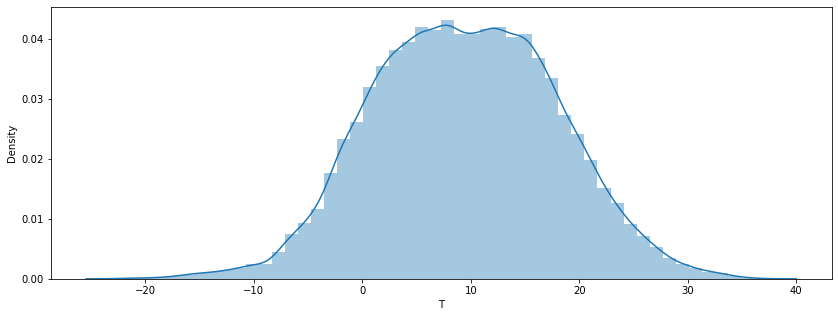

In [80]:
plt.figure(figsize = (14,5))
sns.distplot(df_hour_lvl['T'])

#### The data is a very good normally distributed data. If our data was not normally distributed, then we had to convert it into normal data using outlier removal or data transformation (usually Box-Cox Transformation) or both. In my experience, LSTMs provide very bad forecast on skewed data. As of now, this data is fine and we can proceed with this data

In [203]:
# we cannot simply provide a sequence of data points to an RNN (LSTM here) model, 
# the input training sequence must be a 2D array while the 

def Sequential_Input_LSTM(df, input_sequence):
    df_as_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_as_np) - input_sequence):
        row = [a for a in df_as_np[i:i + input_sequence]]
        X.append(row)
        label = df_as_np[i + input_sequence]
        y.append(label)
        
    return np.array(X), np.array(y)

In [85]:
n_input = 10      # number of historical inputs used for forecasting the time series 

df_min_model_data = df_hour_lvl['T']

X, y = Sequential_Input_LSTM(df_min_model_data, n_input)

In [86]:
X.shape, y.shape

((70081, 10), (70081,))

In [103]:
# Training data
X_train, y_train = X[:60000], y[:60000]

# Validation data
X_val, y_val = X[60000:65000], y[60000:65000]

# Test data
X_test, y_test = X[65000:], y[65000:]

In [104]:
X_train.shape, y_train.shape

((60000, 10), (60000,))

In [205]:
X_train.ndim, y_train.ndim

(2, 1)

In [105]:
X_val.shape, y_val.shape

((5000, 10), (5000,))

In [106]:
X_test.shape, y_test.shape

((5081, 10), (5081,))

In [107]:
# hours
print('Temp :')
print()
print(f'Total days      : {len(df_hour_lvl)/24}')
print(f'Training days   : {len(X_train)/24}')
print(f'Validation days : {len(X_val)/24}')
print(f'Testing days    : {len(X_test)/24}')

Temp :

Total days      : 2920.4583333333335
Training days   : 2500.0
Validation days : 208.33333333333334
Testing days    : 211.70833333333334


## Creating the LSTM Model

In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

####  We are using 3 layers of LSTM (called Stacked/Deep LSTM) instead of just 1 layer, for better forecast. 

#### Note : use "return_sequences = True" if using multiple LSTM layers, except in the last layer.

In [168]:
n_features = 1                        # number of input variables used for forecast (here, only 1 i.e. temperature)

model1 = Sequential()

model1.add(InputLayer((n_input,n_features)))
model1.add(LSTM(100, return_sequences = True))     
model1.add(LSTM(100, return_sequences = True))
model1.add(LSTM(50))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 100)           40800     
                                                                 
 lstm_4 (LSTM)               (None, 10, 100)           80400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dense_4 (Dense)             (None, 8)                 408       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 151,817
Trainable params: 151,817
Non-trainable params: 0
_________________________________________________________________


In [169]:
cp1 = ModelCheckpoint('Model1/',save_best_only = True)

early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

model1.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.0001), metrics = RootMeanSquaredError())

In [170]:
model1.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 50, callbacks = [cp1, early_stop])

Epoch 1/50
1873/1875 [============================>.] - ETA: 0s - loss: 18.8846 - root_mean_squared_error: 4.3456

INFO:tensorflow:Assets written to: Model1\assets


INFO:tensorflow:Assets written to: Model1\assets


1875/1875 [==============================] - 66s 32ms/step - loss: 18.8656 - root_mean_squared_error: 4.3435 - val_loss: 1.1583 - val_root_mean_squared_error: 1.0762
Epoch 2/50
1872/1875 [============================>.] - ETA: 0s - loss: 1.5964 - root_mean_squared_error: 1.2635

INFO:tensorflow:Assets written to: Model1\assets


INFO:tensorflow:Assets written to: Model1\assets


1875/1875 [==============================] - 58s 31ms/step - loss: 1.5953 - root_mean_squared_error: 1.2631 - val_loss: 0.6021 - val_root_mean_squared_error: 0.7759
Epoch 3/50
1875/1875 [==============================] - ETA: 0s - loss: 0.8332 - root_mean_squared_error: 0.9128

INFO:tensorflow:Assets written to: Model1\assets


INFO:tensorflow:Assets written to: Model1\assets


1875/1875 [==============================] - 61s 32ms/step - loss: 0.8332 - root_mean_squared_error: 0.9128 - val_loss: 0.5629 - val_root_mean_squared_error: 0.7503
Epoch 4/50
1872/1875 [============================>.] - ETA: 0s - loss: 0.6910 - root_mean_squared_error: 0.8313

INFO:tensorflow:Assets written to: Model1\assets


INFO:tensorflow:Assets written to: Model1\assets


1875/1875 [==============================] - 61s 33ms/step - loss: 0.6911 - root_mean_squared_error: 0.8313 - val_loss: 0.4881 - val_root_mean_squared_error: 0.6987
Epoch 5/50
1875/1875 [==============================] - 35s 19ms/step - loss: 0.6581 - root_mean_squared_error: 0.8112 - val_loss: 0.5536 - val_root_mean_squared_error: 0.7440
Epoch 6/50
1874/1875 [============================>.] - ETA: 0s - loss: 0.6418 - root_mean_squared_error: 0.8011

INFO:tensorflow:Assets written to: Model1\assets


INFO:tensorflow:Assets written to: Model1\assets


1875/1875 [==============================] - 59s 32ms/step - loss: 0.6417 - root_mean_squared_error: 0.8011 - val_loss: 0.4840 - val_root_mean_squared_error: 0.6957
Epoch 7/50
1875/1875 [==============================] - 33s 18ms/step - loss: 0.6328 - root_mean_squared_error: 0.7955 - val_loss: 0.5021 - val_root_mean_squared_error: 0.7086
Epoch 8/50
1875/1875 [==============================] - 33s 18ms/step - loss: 0.6281 - root_mean_squared_error: 0.7925 - val_loss: 0.5246 - val_root_mean_squared_error: 0.7243


In [171]:
losses_df1 = pd.DataFrame(model1.history.history)
losses_df1

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,18.865610,4.343456,1.158282,1.076235
1,1.595307,1.263054,0.602081,0.775939
2,0.833241,0.912821,0.562950,0.750300
3,0.691060,0.831300,0.488125,0.698660
4,0.658123,0.811248,0.553583,0.744031
5,0.641727,0.801078,0.484023,0.695718
6,0.632758,0.795461,0.502106,0.708594
7,0.628112,0.792535,0.524623,0.724309


<AxesSubplot:>

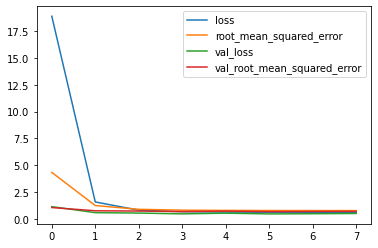

In [172]:
losses_df1.plot()

In [173]:
test_predictions1 = model1.predict(X_test).flatten()
test_predictions1

array([12.463134 , 11.68335  , 12.067884 , ..., -1.891903 , -2.7416756,
       -3.1969934], dtype=float32)

In [174]:
len(X_test), len(test_predictions1)

(5081, 5081)

In [175]:
test_predictions1.ndim

1

In [176]:
X_test_list = []
for i in range(len(X_test)):
    X_test_list.append(X_test[i][0])
    
len(X_test_list)

5081

In [177]:
test_predictions_df1 = pd.DataFrame({'X_test':list(X_test_list), 'LSTM Prediction':list(test_predictions1)})
len(test_predictions_df1)

5081

In [178]:
test_predictions_df1

,X_test,LSTM Prediction
0,18.27,12.463134
1,17.85,11.683350
2,16.65,12.067884
3,15.85,16.360687
4,15.09,20.412607
...,...,...
5076,-6.31,-1.104804
5077,-5.02,-1.528120
5078,-3.31,-1.891903
5079,-0.71,-2.741676


### LSTM temperature forecast on complete Test Data (211.7 days)

<AxesSubplot:>

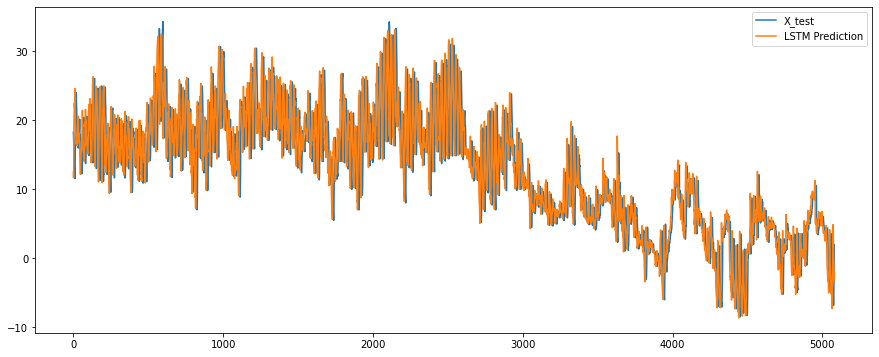

In [179]:
test_predictions_df1.plot(figsize = (15,6))

### LSTM temperature forecast on last 1 Month in the Test Data (720 hours)

<AxesSubplot:>

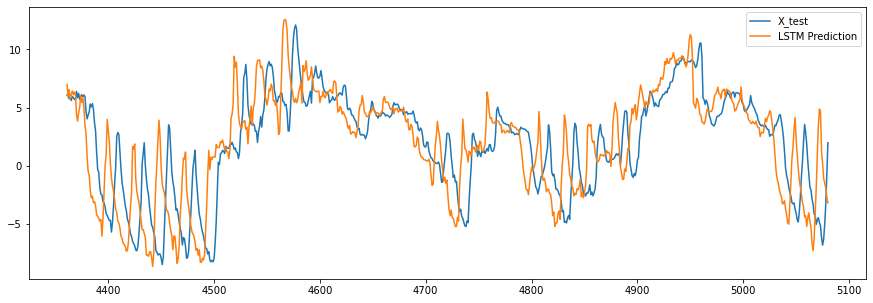

In [180]:
test_predictions_df1[(len(X_test) - 720):].plot(figsize = (15,5))

## Now Making Future Forecast using LSTM model

In [140]:
from sklearn.metrics import mean_squared_error as mse

In [200]:
def futureForecast(df, col, n_input, n_features, forecast_timeperiod, model):

    x_input = np.array(df[len(df)-n_input:][col])

    temp_input=list(x_input)

    lst_output=[]
    i=0

    while(i < forecast_timeperiod):

        if(len(temp_input) > n_input):

            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape((1, n_input, n_features))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])
            temp_input = temp_input[1:]
            lst_output.append(yhat[0][0])

            i=i+1

        else:
            x_input = x_input.reshape((1, n_input, n_features))
            yhat = model.predict(x_input, verbose=0)
            #print(yhat[0])
            temp_input.append(yhat[0][0])
            lst_output.append(yhat[0][0])

            i=i+1
            
    return lst_output

In [182]:
df_hour_lvl.head()

,datetime,T
0,2009-01-01 01:00:00,-8.05
1,2009-01-01 02:00:00,-8.88
2,2009-01-01 03:00:00,-8.81
3,2009-01-01 04:00:00,-9.05
4,2009-01-01 05:00:00,-9.63


In [201]:
n_input = 10
n_features = 1
forecast_timeperiod = 240         # next 10 days
model = model1

forecast_output = futureForecast(df_hour_lvl, 'T', n_input, n_features, forecast_timeperiod, model)

In [184]:
len(forecast_output)

240

In [197]:
last_10_days = df_hour_lvl['T'][len(df_hour_lvl) - 240:].tolist()

next_10_days = pd.DataFrame(forecast_output, columns = ['FutureForecast'])

In [198]:
next_10_days.head()

,FutureForecast
0,-4.233576
1,-4.377257
2,-4.363905
3,-4.128469
4,-3.689097


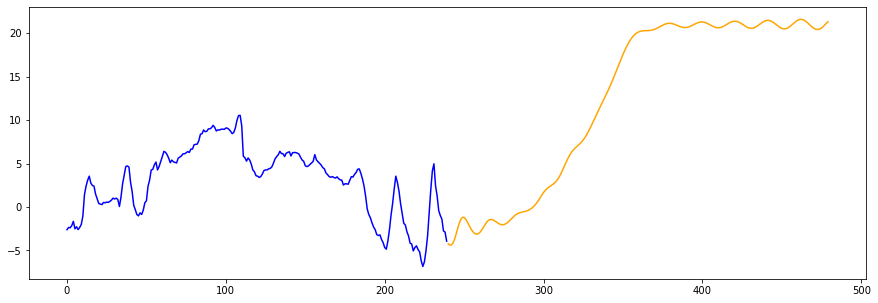

In [187]:
plt.figure(figsize = (15,5))

hist_axis = len(last_10_days)
forecast_axis = hist_axis + len(next_10_days)

plt.plot(np.arange(0,hist_axis),last_10_days, color = 'blue')
plt.plot(np.arange(hist_axis,forecast_axis),next_10_days['FutureForecast'].tolist(), color = 'orange')

## Thank you

### Feel free to connect with me for further discussions on Time Series Analysis.

#### LinkedIn : https://www.linkedin.com/in/vineet-pandya/

#### Medium : https://medium.com/@vineet.pandya

#### Email : vineet.pandya@yahoo.com